# Multiforest optimization notebook


Above the code cells, there are short instructions how the users can modify the codes in the cells. If there are no instructions, no changes should be needed for the cell by default.

A detailed description is provided in the README.md.

## Basic definitions
Simulated forest data - name and climate scenario

In [1]:
RCP = "RCP0" # no climate change

Specify policy scenario:

- "FS" -  National Forest Strategy
- "BDS" - Biodiversity Strategy
- "BES" - Bioeconomy Strategy

In [2]:
scenario ="BES"

## Read the data

In [3]:
import os
import numpy as np
import sys
import requests

### Read .py class

In [4]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/py_class")

import multiFunctionalOptimization as MFO

In [5]:
from importlib import reload
reload(MFO)

<module 'multiFunctionalOptimization' from '/home/ubuntu/workspace/mf_optimization_demo/py_class/multiFunctionalOptimization.py'>

In [6]:
mfo = MFO.MultiFunctionalOptimization()

'Using CLP'

In [7]:
filename = "rslt_"+RCP+"_Bavaria_Germany_pause_2_V1_sample.zip"
filename

'rslt_RCP0_Bavaria_Germany_pause_2_V1_sample.zip'

### Import data

In [8]:
if not filename in os.listdir("."):
    url = "https://syncandshare.lrz.de/dl/fiD3UdeLAsM5Uuc2Vy3yguCR/rslt_RCP0_Bavaria_Germany_pause_2_V1.zip"
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)

### Read data

In [9]:
%%time
mfo.readData(filename,
             sampleRatio=0.2 #If no sample ratio given, the ratio is assumed to be 1
                             #0.2 means 20% of the data
            ) 

'sample size 111/558(19%)'

CPU times: user 1.29 s, sys: 192 ms, total: 1.48 s
Wall time: 1.48 s


In [10]:
mfo.data.columns

Index(['Unnamed: 0', 'id', 'regime', 'year', 'ecoregion', 'V_strat',
       'V_strat_reg', 'Ve_strat', 'Vm_strat', 'iV_strat', 'pct_coni',
       'pct_reg_coni', 'pct_deci', 'pct_reg_deci', 'spruce_pct',
       'spruce_reg_pct', 'fir_pct', 'fir_reg_pct', 'pine_pct', 'pine_reg_pct',
       'larch_pct', 'larch_reg_pct', 'beech_pct', 'beech_reg_pct', 'oak_pct',
       'oak_reg_pct', 'douglasfir_pct', 'douglasfir_reg_pct', 'hardbrl_pct',
       'hardbrl_reg_pct', 'softbrl_pct', 'softbrl_reg_pct', 'spi', 'spi_reg',
       'maxh', 'maxh_reg', 'spint', 'freq_h_0_50', 'freq_h_50_80',
       'freq_h_80_100', 'cntlayers', 'shan_species', 'shan_species_reg',
       'shan_height', 'volHa_dbhGR10', 'volHa_dbhGR20', 'volHa_dbhGR30',
       'volHa_dbhGR40', 'volHa_dbhGR50', 'volHa_dbhGR60', 'volHa_dead_dbhGR30',
       'volHa_dead_dbhGR40', 'volHa_dead_dbhGR50', 'volHa_dead_dbhGR60',
       'sawntimber', 'industrywood', 'yieldloss', 'remaininstand',
       'represented_area_by_NFIplot', 'region', 'NU

## Create new columns

In [11]:
mfo.data["HarvestedVolume"] = (mfo.data["Ve_strat"].values)*mfo.data["represented_area_by_NFIplot"].values

In [12]:
mfo.data["CarbonBalance"] = (mfo.data["BalanceCarbonTotalYear"].values)*mfo.data["represented_area_by_NFIplot"].values

In [13]:
mfo.data["AnnualIncrement"] = mfo.data["iV_strat"].values*mfo.data["represented_area_by_NFIplot"].values

In [14]:
mfo.data["speciesProfileIndex"] = mfo.data["spi"].values 

In [15]:
mfo.data["VolumeLargeTrees"] = mfo.data["volHa_dbhGR60"].values*mfo.data["represented_area_by_NFIplot"].values

In [16]:
mfo.data["speciesInterminglingIndex"] = mfo.data["spint"].values

In [17]:
mfo.data["ShannonIndexSpecies"] = mfo.data["shan_species"].values

In [18]:
mfo.data["ShannonIndexTreeHeight"] = mfo.data["shan_height"].values

In [19]:
mfo.data["standingVolume"] = mfo.data["V_strat"]*mfo.data["represented_area_by_NFIplot"].values

In [20]:
mfo.data["noNaturalSpecies"] = mfo.data.apply(lambda x: sum([x[name] for name in mfo.data.columns if "pnv" in name]),axis=1)

In [21]:
mfo.data["stateForest"] = mfo.data['landtenure'].apply(lambda x: 1 if x < 1000 else 0)

In [22]:
mfo.data["SawTimber"] = mfo.data["V Sawlogs"].values*mfo.data["represented_area_by_NFIplot"].values

In [23]:
mfo.data["PulpWood"] =mfo.data["V PulpWood"].values*mfo.data["represented_area_by_NFIplot"].values

In [24]:
mfo.data["ForestResidues"] =mfo.data["V HarvestResidues"].values*mfo.data["represented_area_by_NFIplot"].values

In [25]:
mfo.data["Fuelwood"] = mfo.data["fuelwood"].values*mfo.data["represented_area_by_NFIplot"].values

In [26]:
mfo.data["energyProds"] =mfo.data["CFsawlogsToEnergy"].values*mfo.data["represented_area_by_NFIplot"].values

In [27]:
mfo.data["TotalLivingCarbon"] = (mfo.data["CSagbLivingTotal"].values + mfo.data["CSbgbLivingTotal"].values )*mfo.data["represented_area_by_NFIplot"].values

In [28]:
mfo.data["pnvDeviation"] =((mfo.data["pnv_spruce"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["spruce_pct"].values)**2 + 
                      (mfo.data["pnv_beech"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["beech_pct"].values)**2 +
                      (mfo.data["pnv_pine"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["pine_pct"].values)**2+
                      (mfo.data["pnv_fir"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["fir_pct"].values)**2+
                      (mfo.data["pnv_oak"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["oak_pct"].values)**2)

<ipython-input-28-a5a52783099c>:1: RuntimeWarning: invalid value encountered in true_divide
  mfo.data["pnvDeviation"] =((mfo.data["pnv_spruce"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["spruce_pct"].values)**2 +
<ipython-input-28-a5a52783099c>:2: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_beech"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["beech_pct"].values)**2 +
<ipython-input-28-a5a52783099c>:3: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_pine"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["pine_pct"].values)**2+
<ipython-input-28-a5a52783099c>:4: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_fir"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["fir_pct"].values)**2+
<ipython-input-28-a5a52783099c>:5: RuntimeWarning: invalid value encountered in true_divide
  (mfo.data["pnv_oak"].values*100/mfo.data["noNaturalSpecies"].values - mfo.data["o

In [29]:
import numpy as np

In [30]:
mfo.data["pnvDeviation"].replace(np.nan,0,inplace=True)

In [31]:
mfo.data["pnvDeviation"]

0          1312.1442
1           669.2418
2           253.0509
3           180.5765
4           114.9700
             ...    
167050    12500.0000
167051    12500.0000
167052    12500.0000
167053    12500.0000
167054    12500.0000
Name: pnvDeviation, Length: 33411, dtype: float64

In [32]:
mfo.data[mfo.regimesEnu].value_counts()

BAU_RR_p2        2220
NOT              2220
CCF_P1           2220
CCF_P3_p2        2220
BAU_RR_p1        2220
BAU_0_p2         2220
BAU_0_p1         2220
BAU_FS1          2220
BAU_0            2220
CCF_P3           2220
BAU_RR           2220
CCF_P3_p1        2220
CCF_P2           2220
CCF_STATE        2220
BAU_1            2220
initial_state     111
Name: regime, dtype: int64

### add column to restrict SA¶

In [33]:
regimeClassNames = {"regimeClass0name":"CCF","regimeClass1name":"SA"}
regimeClassregimes = {"regimeClass0regimes":["CCF_P3 ","CCF_P3_p1","CCF_P3_p2"],"regimeClass1regimes":["NOT"]}

In [34]:
mfo.addRegimeClassifications(regimeClassNames = regimeClassNames,regimeClassregimes=regimeClassregimes)

In [35]:
mfo.finalizeData(initialRegime="initial_state")

In [36]:
mfo.initialData.head()

,,,Unnamed: 0,ecoregion,V_strat,V_strat_reg,Ve_strat,Vm_strat,iV_strat,pct_coni,pct_reg_coni,pct_deci,...,stateForest,SawTimber,PulpWood,ForestResidues,Fuelwood,energyProds,TotalLivingCarbon,pnvDeviation,CCF_forests,SA_forests
id,year,regime,,,,,,,,,,,,,,,,,,,,,
14,2012,initial_state,4194,9.5.2,182.529,0.0,0.0,0.0,182.529,5.0,0.0,95.0,...,1,0.0,0.0,0.0,0.0,0.0,36610.730548,2207.9282,False,False
24,2012,initial_state,7204,9.11.2,258.004,0.0,0.0,0.0,258.004,52.0,0.0,48.0,...,1,0.0,0.0,0.0,0.0,0.0,48240.751804,5332.7780,False,False
41,2012,initial_state,12321,9.12.7,254.322,0.0,0.0,0.0,254.322,12.0,0.0,88.0,...,1,0.0,0.0,0.0,0.0,0.0,101169.207110,4572.0128,False,False
103,2012,initial_state,30983,9.5.1,531.134,0.0,0.0,0.0,531.134,87.0,0.0,13.0,...,1,0.0,0.0,0.0,0.0,0.0,92104.341924,11499.7094,False,False
128,2012,initial_state,38508,9.5.1,493.845,0.0,0.0,0.0,493.845,54.0,0.0,46.0,...,1,0.0,0.0,0.0,0.0,0.0,91992.824322,3772.9517,False,False


In [37]:
mfo.data.head()

Unnamed: 0 ecoregion  V_strat  V_strat_reg  Ve_strat  \
id year regime                                                           
14 2017 BAU_0           3914     9.5.2  193.311        5.305    29.133   
        BAU_0_p1        3934     9.5.2  193.368        5.177    28.305   
        BAU_0_p2        3954     9.5.2  187.269        5.972    31.093   
        BAU_1           3974     9.5.2  193.731        5.946    28.088   
        BAU_FS1         3994     9.5.2  193.665        6.540    29.521   

                  Vm_strat  iV_strat  pct_coni  pct_reg_coni  pct_deci  ...  \
id year regime                                                          ...   
14 2017 BAU_0       21.213    61.128       4.0           5.0      96.0  ...   
        BAU_0_p1    21.771    60.915       3.0           3.0      97.0  ...   
        BAU_0_p2    18.969    54.802       3.0           3.0      97.0  ...   
        BAU_1       21.965    61.255       3.0           5.0      97.0  ...   
        BAU_FS1     20.582    61.239       3.0           6.0      97.0  ...   

                  Relative_relative_Volume  Relative_AnnualIncrement  \
id year regime                                                         
14 2017 BAU_0                     0.009009                  0.000714   
        BAU_0_p1                  0.009009                  0.000711   
        BAU_0_p2                  0.009009                  0.000640   
        BAU_1                     0.009009                  0.000715   
        BAU_FS1                   0.009009                  0.000715   

                  Relative_speciesProfileIndex  Relative_VolumeLargeTrees  \
id year regime                                                              
14 2017 BAU_0                         0.013684                        0.0   
        BAU_0_p1                      0.013565                        0.0   
        BAU_0_p2                      0.013934                        0.0   
        BAU_1                         0.013803                        0.0   
        BAU_FS1                       0.013771                        0.0   

                  Relative_speciesInterminglingIndex  \
id year regime                                         
14 2017 BAU_0                               0.020984   
        BAU_0_p1                            0.020984   
        BAU_0_p2                            0.020984   
        BAU_1                               0.020984   
        BAU_FS1                             0.020984   

                  Relative_ShannonIndexSpecies  \
id year regime                                   
14 2017 BAU_0                         0.023174   
        BAU_0_p1                      0.023174   
        BAU_0_p2                      0.023174   
        BAU_1                         0.023174   
        BAU_FS1                       0.023174   

                  Relative_ShannonIndexTreeHeight  Relative_standingVolume  \
id year regime                                                               
14 2017 BAU_0                            0.033830                 0.002257   
        BAU_0_p1                         0.033826                 0.002258   
        BAU_0_p2                         0.033789                 0.002186   
        BAU_1                            0.033840                 0.002262   
        BAU_FS1                          0.033817                 0.002261   

                  Relative_TotalLivingCarbon  Relative_pnvDeviation  
id year regime                                                       
14 2017 BAU_0                       0.002585               0.001356  
        BAU_0_p1                    0.002589               0.001273  
        BAU_0_p2                    0.002507               0.001255  
        BAU_1                       0.002594               0.001044  
        BAU_FS1                     0.002593               0.000987  

[5 rows x 160 columns]

## Objectives

### FS - Forest Strategy

In [38]:
if scenario == 'FS':
    
    objectives_abs = {
        "HarvestedVolume": ["Sum of extracted volume (maximize, m3/ha) (4)","HarvestedVolume",
                            "max","min","areaWeightedAverage"],
        "AnnualIncrement": ["Annual increment of standing volume (maximimze, m3/ha/5year) (4)","AnnualIncrement",
                            "max","min","areaWeightedAverage"],
        "CteStandingVolume" : ["Standing volume must be maintained ct. (m3) (4)", "Relative_standingVolume",
                             "max", "minYearlyIncrease", "areaWeightedAverage"],
        "EnergyWood" : ["Energy Wood for industry must be maintained ct. (tC) (3)", "energyProds", 
                       "max", "minYearlyIncrease", "sum"],
        "totalCarbonBalance" : ["carbon balance must be constant or maximized (tC) (2)", "CarbonBalance",
                             "max", "min", "sum"]  
    }
    objectives_rel = {
        "speciesProfileIndex": ["Species profile index (Pretzsch) (maximize the mean) (2)","speciesProfileIndex",
                             "max","average","areaWeightedAverage"],                           
        "ShannonIndexSpecies": ["Shannon index of species (maximize the mean) (2)","ShannonIndexSpecies",
                            "max","average","areaWeightedAverage"],
        "RiskStormBB" :["Risk of storms and Bark Beetel (minimize the maximum risk) (2)", "Relative_stormBBRisk", 
                       "min", "max","areaWeightedAverage"],
        "RecreationAsth" : ["Recreation and Aesthetics maximize the mean) (4)", "RecreationAndAesthetics",
                           "max", "average", "areaWeightedAverage"],
        "Biodiveristy": ["Biodiversity fuzzy indicator (mantain ct, evenflow) (4)", "Biodiversity", 
                             "max", "average", "areaWeightedAverage"],
        "CrownCoverage":["Mean Crown coverage must be maintened (minimize change, evenflow) (4)","covered_area_per",
                         "max", "min", "areaWeightedAverage"],
    }

    objectives = {
        **objectives_abs,
        **objectives_rel,
    }

### BDS - Biodiversity Strategy

In [39]:
if scenario == 'BDS':
    objectives_abs = {
    "totalCarbonBalance" : ["carbon balance must be constant or increase (tC) (4)", "CarbonBalance",
                         "max", "average", "areaWeightedAverage"]
    }
    objectives_rel = {
    "relative_LivingCarbon": ["Living carbon stored in Forests must increase by 5% by 2020 (tC - 10% relative to 2007 values) (4)", "Relative_TotalLivingCarbon",
                                "max","targetYearWithSlope","sum", 2020],
    "speciesProfileIndex": ["Species profile index (Pretzsch) (maximum over all years)  (4)","speciesProfileIndex",
                         "max","average","areaWeightedAverage"],  
    "ShannonIndexSpecies": ["Shannon index of species (maximum over all years) (4)","ShannonIndexSpecies",
                        "max","average","areaWeightedAverage"],
    "Biodiveristy": ["Biodiversity fuzzy indicator (maximum over all years) (4)", "Biodiversity", 
                         "max", "average", "areaWeightedAverage"],

    }
    objectives_SA = {
 
     "Ratio_SA_forests": ["Ratio of protected areas (%, SA forests) (1)",
                         "SA_forests",
                         "max","firstYear","areaWeightedAverage"]  
    }
    objectives = {
        **objectives_SA,
        **objectives_abs,
        **objectives_rel,
    }
    objectives.update(
        {"pnvDeviation": ["deviation from potential natural vegetation (min over all years) (4)","pnvDeviation",
        "min","max","areaWeightedAverage"],
        }
    )
    

### BES - Bioeconomy Strategy

In [40]:
if scenario == 'BES':
    
    objectives_abs = {
        
    "energyproducts": ["remaning products for energy use (tC maximize) (4)", "energyProds",
                        "max","min","sum"],
    "PulpWood" : ["wood products for industry (m3 maximize)  (4)", "PulpWood",
                        "max","min","sum"],
    "totalCarbonBalance" : ["carbon balance must be constant or increase (tC) (2)", "CarbonBalance",
                         "max", "average", "sum"],
    "SawTimberProduction" : ["timber production (m3 maximize) (4)", "SawTimber",
                         "max", "min", "sum"],

    }
    objectives_rel = {
        
     "Biodiversity": ["Biodiversity fuzzy indicator (maximize) (1)", "Biodiversity", 
                    "max", "min", "areaWeightedAverage"],
     "CrownCoverage":["Mean Crown coverage must be maintened ct (% cover) (1)","covered_area_per",
                     "max", "min", "areaWeightedAverage"],
    }
    objectives = {
        **objectives_abs,
        **objectives_rel,
    }
    

In [41]:
objectives

{'energyproducts': ['remaning products for energy use (tC maximize) (4)',
  'energyProds',
  'max',
  'min',
  'sum'],
 'PulpWood': ['wood products for industry (m3 maximize)  (4)',
  'PulpWood',
  'max',
  'min',
  'sum'],
 'totalCarbonBalance': ['carbon balance must be constant or increase (tC) (2)',
  'CarbonBalance',
  'max',
  'average',
  'sum'],
 'SawTimberProduction': ['timber production (m3 maximize) (4)',
  'SawTimber',
  'max',
  'min',
  'sum'],
 'Biodiversity': ['Biodiversity fuzzy indicator (maximize) (1)',
  'Biodiversity',
  'max',
  'min',
  'areaWeightedAverage'],
 'CrownCoverage': ['Mean Crown coverage must be maintened ct (% cover) (1)',
  'covered_area_per',
  'max',
  'min',
  'areaWeightedAverage']}

In [42]:
mfo.defineObjectives(objectives)

'Defining objectives'

'Aggregating stand wise'

100%|██████████| 6/6 [00:01<00:00,  3.25it/s]


'Aggregating year wise'

100%|██████████| 6/6 [00:00<00:00, 380.94it/s]


'Objectives added'

## Define Enabled Constrains


In [43]:
NotCCregimes = [regime for regime in mfo.regimes if "BAU" not in regime] 

In [44]:
NotCCregimes

['CCF_P1', 'CCF_P2', 'CCF_P3', 'CCF_P3_p1', 'CCF_P3_p2', 'CCF_STATE', 'NOT']

Constraint format:

- Shortname: "constraint type","allowed regimes","human readable name",(regimes),"column in data")

In [45]:
constraintTypes = {"NoCC_Prot":["Allowed regimes","NO CleatCut on protected land",NotCCregimes,"protected"],
                   "NoCC_State":["Allowed regimes","NO CleatCut on state forest",NotCCregimes,"stateForest"]}

In [46]:
mfo.defineConstraints(constraintTypes)

## Calculate objective ranges

You can run the following function twice to improve ranges accuracy.

Especially, if some objectives get as lowerbounds 0:s, then it makes sense to reoptimize

In [47]:

%%time
mfo.calculateObjectiveRanges(debug=True)

'Calculating objective ranges'

  0%|          | 0/6 [00:00<?, ?it/s]

'Optimizing for remaning products for energy use (tC maximize) (4)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

353236.70445831143

'wood products for industry (m3 maximize)  (4)'

0.0

'carbon balance must be constant or increase (tC) (2)'

229634.75133772852

'timber production (m3 maximize) (4)'

0.0

'Biodiversity fuzzy indicator (maximize) (1)'

0.0

'Mean Crown coverage must be maintened ct (% cover) (1)'

0.0

 17%|█▋        | 1/6 [00:00<00:01,  2.72it/s]

'Optimizing for wood products for industry (m3 maximize)  (4)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

0.0

'wood products for industry (m3 maximize)  (4)'

4441113.589210781

'carbon balance must be constant or increase (tC) (2)'

-41671.71647991123

'timber production (m3 maximize) (4)'

0.0

'Biodiversity fuzzy indicator (maximize) (1)'

0.0

'Mean Crown coverage must be maintened ct (% cover) (1)'

0.0

 33%|███▎      | 2/6 [00:00<00:01,  3.15it/s]

'Optimizing for carbon balance must be constant or increase (tC) (2)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

0.0

'wood products for industry (m3 maximize)  (4)'

0.0

'carbon balance must be constant or increase (tC) (2)'

498170.1682110192

'timber production (m3 maximize) (4)'

0.0

'Biodiversity fuzzy indicator (maximize) (1)'

0.0

'Mean Crown coverage must be maintened ct (% cover) (1)'

0.0

 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

'Optimizing for timber production (m3 maximize) (4)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

0.0

'wood products for industry (m3 maximize)  (4)'

0.0

'carbon balance must be constant or increase (tC) (2)'

226865.9252195332

'timber production (m3 maximize) (4)'

16428819.654257894

'Biodiversity fuzzy indicator (maximize) (1)'

0.0

'Mean Crown coverage must be maintened ct (% cover) (1)'

0.0

 67%|██████▋   | 4/6 [00:00<00:00,  4.07it/s]

'Optimizing for Biodiversity fuzzy indicator (maximize) (1)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

0.0

'wood products for industry (m3 maximize)  (4)'

0.0

'carbon balance must be constant or increase (tC) (2)'

230683.3940577138

'timber production (m3 maximize) (4)'

0.0

'Biodiversity fuzzy indicator (maximize) (1)'

0.26313645308337125

'Mean Crown coverage must be maintened ct (% cover) (1)'

0.0

 83%|████████▎ | 5/6 [00:01<00:00,  4.36it/s]

'Optimizing for Mean Crown coverage must be maintened ct (% cover) (1)'

'Found an optimal solution in 0 seconds'

'Objective values are:'

'remaning products for energy use (tC maximize) (4)'

0.0

'wood products for industry (m3 maximize)  (4)'

0.0

'carbon balance must be constant or increase (tC) (2)'

260088.03331874666

'timber production (m3 maximize) (4)'

0.0

'Biodiversity fuzzy indicator (maximize) (1)'

0.0

'Mean Crown coverage must be maintened ct (% cover) (1)'

65.88643251581223

100%|██████████| 6/6 [00:01<00:00,  4.58it/s]
CPU times: user 1.15 s, sys: 43.9 ms, total: 1.19 s
Wall time: 1.31 s


In [48]:
mfo.objectiveRanges

{'energyproducts': (0.0, 353236.70445831143),
 'PulpWood': (0.0, 4441113.589210781),
 'totalCarbonBalance': (-41671.71647991123, 498170.1682110192),
 'SawTimberProduction': (0.0, 16428819.654257894),
 'Biodiversity': (0.0, 0.26313645308337125),
 'CrownCoverage': (0.0, 65.88643251581223)}

## Show GUI

- If "Enabled constraints" should be considered, start with ticking box "only CCF ..." and push "Change constraints"
- Epsilon constraints are only considered if sliders are moved and button "Set epsilon constraints" is pushed
- By pushing "OPTIMIZE" an optimal solution under the given constraints and reference points is searched

In [49]:
mfo.showGUI()

interactive(children=(FloatSlider(value=0.0, description='remaning products for energy use (tC maximize) (4)',…

interactive(children=(FloatSlider(value=176618.35222915572, description='remaning products for energy use (tC …

interactive(children=(Checkbox(value=False, description='NO CleatCut on protected land'), Checkbox(value=False…

Button(description='Print solution', style=ButtonStyle())

## Visualization of optimal solution

In [50]:
regimeAmounts = {regime:0 for regime in mfo.regimes}
for key in mfo.regimesDecision.keys():
    regimeAmounts[key[1]] +=mfo.regimesDecision[key].solution_value()*mfo.standAreas.loc[key[0],"represented_area_by_NFIplot"]/mfo.standAreas["represented_area_by_NFIplot"].sum()

In [51]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [52]:
[val for val in regimeAmounts.values()]

[0.0,
 0.011714295906007376,
 0.06395897881580465,
 0.008559746430160085,
 0.017292468854785723,
 0.013001325562820378,
 0.004333775187606793,
 0.08387247395740619,
 0.0,
 0.0,
 0.012893521617782124,
 0.2076967463374368,
 0.2255306449718851,
 0.0,
 0.35114602235830467]

<IPython.core.display.Javascript object>


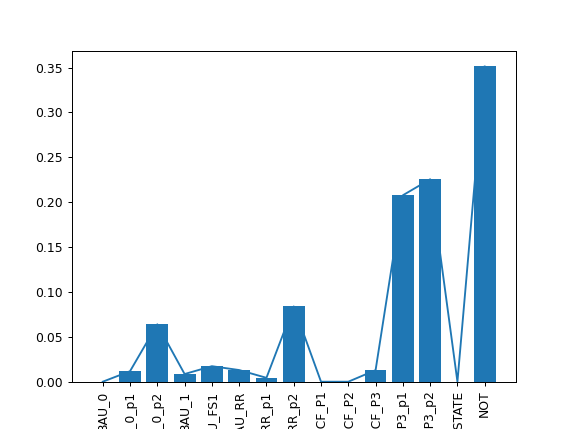

In [53]:
plt.plot([key for key in regimeAmounts.keys()],[val for val in regimeAmounts.values()])

In [54]:
plt.bar(range(len(regimeAmounts)), list(regimeAmounts.values()), align='center')
plt.xticks(range(len(regimeAmounts)), list(regimeAmounts.keys()),rotation="vertical")

([<matplotlib.axis.XTick at 0x7fba17c6b880>,
 [Text(0, 0, 'BAU_0'),
  Text(0, 0, 'BAU_0_p1'),
  Text(0, 0, 'BAU_0_p2'),
  Text(0, 0, 'BAU_1'),
  Text(0, 0, 'BAU_FS1'),
  Text(0, 0, 'BAU_RR'),
  Text(0, 0, 'BAU_RR_p1'),
  Text(0, 0, 'BAU_RR_p2'),
  Text(0, 0, 'CCF_P1'),
  Text(0, 0, 'CCF_P2'),
  Text(0, 0, 'CCF_P3'),
  Text(0, 0, 'CCF_P3_p1'),
  Text(0, 0, 'CCF_P3_p2'),
  Text(0, 0, 'CCF_STATE'),
  Text(0, 0, 'NOT')])

## Export data as csv
- Solution_alldata contains the optimal regime per stand AND the timely development of indicator values plus all other input columns (represented_are_by_NFIplot, region, NUTS2)
- Solution contains only the selected optimal regime and its share (if multiple regimes per stand are selected)

In [55]:
import pandas as pd
import os

In [56]:
import os

try:
    os.mkdir("results")
except FileExistsError:
    pass
b = []
c = []
for key in mfo.regimesDecision.keys():
    if mfo.regimesDecision[key].solution_value() > 0:
        b = b+ [(key[0],x*5+2012, key[1]) for x in range(0,21)]
        c = c+ [(key[0],key[1],mfo.regimesDecision[key].solution_value())]
data2b = mfo.data.iloc[mfo.data.index.isin(b)]
data2b.to_csv("./results/"+scenario+"_"+RCP+"_data.csv")
c1 = pd.DataFrame(c)
c1.to_csv("./results/"+scenario+"_"+RCP+"_solutions.csv")

## Export objective ranges

In [57]:
for key in mfo.regimesDecision.keys():
        print(key,mfo.regimesDecision[key].solution_value())

(14, 'BAU_0') 0.0
(14, 'BAU_0_p1') 0.0
(14, 'BAU_0_p2') 0.0
(14, 'BAU_1') 0.0
(14, 'BAU_FS1') 0.0
(14, 'BAU_RR') 0.0
(14, 'BAU_RR_p1') 0.0
(14, 'BAU_RR_p2') 0.0
(14, 'CCF_P1') 0.0
(14, 'CCF_P2') 0.0
(14, 'CCF_P3') 0.0
(14, 'CCF_P3_p1') 0.0
(14, 'CCF_P3_p2') 1.0
(14, 'CCF_STATE') 0.0
(14, 'NOT') 0.0
(24, 'BAU_0') 0.0
(24, 'BAU_0_p1') 0.0
(24, 'BAU_0_p2') 0.0
(24, 'BAU_1') 0.0
(24, 'BAU_FS1') 0.0
(24, 'BAU_RR') 0.0
(24, 'BAU_RR_p1') 0.0
(24, 'BAU_RR_p2') 0.0
(24, 'CCF_P1') 0.0
(24, 'CCF_P2') 0.0
(24, 'CCF_P3') 0.0
(24, 'CCF_P3_p1') 0.0
(24, 'CCF_P3_p2') 1.0
(24, 'CCF_STATE') 0.0
(24, 'NOT') 0.0
(41, 'BAU_0') 0.0
(41, 'BAU_0_p1') 0.0
(41, 'BAU_0_p2') 0.0
(41, 'BAU_1') 0.0
(41, 'BAU_FS1') 0.0
(41, 'BAU_RR') 0.0
(41, 'BAU_RR_p1') 0.0
(41, 'BAU_RR_p2') 0.0
(41, 'CCF_P1') 0.0
(41, 'CCF_P2') 0.0
(41, 'CCF_P3') 0.0
(41, 'CCF_P3_p1') 1.0
(41, 'CCF_P3_p2') 0.0
(41, 'CCF_STATE') 0.0
(41, 'NOT') 0.0
(103, 'BAU_0') 0.0
(103, 'BAU_0_p1') 0.0
(103, 'BAU_0_p2') 0.0
(103, 'BAU_1') 0.0
(103, 'BAU_FS1') 0

(1838, 'BAU_FS1') 0.0
(1838, 'BAU_RR') 1.0
(1838, 'BAU_RR_p1') 0.0
(1838, 'BAU_RR_p2') 0.0
(1838, 'CCF_P1') 0.0
(1838, 'CCF_P2') 0.0
(1838, 'CCF_P3') 0.0
(1838, 'CCF_P3_p1') 0.0
(1838, 'CCF_P3_p2') 0.0
(1838, 'CCF_STATE') 0.0
(1838, 'NOT') 0.0
(1860, 'BAU_0') 0.0
(1860, 'BAU_0_p1') 0.0
(1860, 'BAU_0_p2') 0.0
(1860, 'BAU_1') 0.0
(1860, 'BAU_FS1') 0.0
(1860, 'BAU_RR') 0.0
(1860, 'BAU_RR_p1') 0.0
(1860, 'BAU_RR_p2') 0.0
(1860, 'CCF_P1') 0.0
(1860, 'CCF_P2') 0.0
(1860, 'CCF_P3') 0.0
(1860, 'CCF_P3_p1') 0.0
(1860, 'CCF_P3_p2') 0.9999999999999999
(1860, 'CCF_STATE') 0.0
(1860, 'NOT') 0.0
(2023, 'BAU_0') 0.0
(2023, 'BAU_0_p1') 0.0
(2023, 'BAU_0_p2') 0.0
(2023, 'BAU_1') 0.0
(2023, 'BAU_FS1') 0.0
(2023, 'BAU_RR') 0.0
(2023, 'BAU_RR_p1') 0.0
(2023, 'BAU_RR_p2') 1.0
(2023, 'CCF_P1') 0.0
(2023, 'CCF_P2') 0.0
(2023, 'CCF_P3') 0.0
(2023, 'CCF_P3_p1') 0.0
(2023, 'CCF_P3_p2') 0.0
(2023, 'CCF_STATE') 0.0
(2023, 'NOT') 0.0
(2057, 'BAU_0') 0.0
(2057, 'BAU_0_p1') 0.0
(2057, 'BAU_0_p2') 0.0
(2057, 'BAU_1')

Save as json file

In [58]:
import json
mfo.objectiveRanges

with open('./objectiveRanges_'+scenario+'_'+RCP+'.json', 'w') as json_file:
  json.dump(mfo.objectiveRanges, json_file)

Save as CSV.

In [59]:
import pandas
df = pandas.read_json('./objectiveRanges_'+scenario+'_'+RCP+'.json')

df.to_csv('./objectiveRanges_'+scenario+'_'+RCP+'.csv')

## Export objective values
The optimal solution for each objective.

In [60]:
import os
with open("./objectiveValues_"+scenario+"_"+RCP+".csv","w") as file:
    delim = ""
    for objName in mfo.objectiveTypes.keys():
        file.write(delim+objName)
        delim = ","
    file.write("\n")
    delim = ""
    for objName in mfo.objectiveTypes.keys():
        file.write(delim+str(mfo.objective[objName].solution_value()))
        delim = ","
    file.write("\n")